In [2]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil
import tensorflow as tf
from sklearn.model_selection import train_test_split
from PIL import Image
import seaborn as sns
from termcolor import colored
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

import matplotlib.pyplot as plt

# Tensorflow Libraries
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Conv2D, Flatten, RandomHeight, RandomWidth, RandomZoom, RandomBrightness
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer
from keras.utils import plot_model
from tensorflow.keras import optimizers

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("fakhrizakiiii/face-shape-dataset-with-validation")

print("Path to dataset files:", path)

# data_dir = '/kaggle/input/face-shape-new/face-shape-new/training_set'

100%|██████████| 479M/479M [00:07<00:00, 70.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/fakhrizakiiii/face-shape-dataset-with-validation/versions/1


In [4]:
TRAIN_DIR = os.path.join(path, 'train')
# TEST_DIR = '/kaggle/input/face-shape-new/face-shape-new/test_set'

In [5]:
classes = [i for i in os.listdir(TRAIN_DIR) if '.' not in i]
classes

['Oblong', 'Heart', 'Oval', 'Round', 'Square']

In [6]:
from PIL import Image
import os
import pandas as pd
from collections import defaultdict

def filter_rgb_images_by_class(directory, min_width=224, min_height=224):
    # List untuk menyimpan informasi gambar yang memenuhi syarat
    filtered_images = []

    for root, dirs, files in os.walk(directory):
        # Nama kelas diambil dari nama subdirektori
        class_name = os.path.basename(root)
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):  # Pastikan hanya file gambar
                img_path = os.path.join(root, file)
                try:
                    # Buka gambar dan periksa mode
                    with Image.open(img_path) as img:
                        if img.mode == "RGB":
                            # Mendapatkan ukuran (shape) gambar
                            width, height = img.size
                            # Filter berdasarkan ukuran minimal
                            if width >= min_width and height >= min_height:
                                # Simpan informasi gambar ke list
                                filtered_images.append({'path': img_path, 'label': class_name})
                except Exception as e:
                    print(f"Error processing {file}: {e}")

    # Mengonversi list hasil filter menjadi DataFrame
    return pd.DataFrame(filtered_images)



In [7]:
# Menggunakan fungsi untuk TEST_DIR
print("\nFiltering RGB images from TEST_DIR with minimum size 160x160:")
data = filter_rgb_images_by_class(TRAIN_DIR, min_width=224, min_height=224)


Filtering RGB images from TEST_DIR with minimum size 160x160:


In [8]:
data.tail()

path   label
10011  /root/.cache/kagglehub/datasets/fakhrizakiiii/...  Square
10012  /root/.cache/kagglehub/datasets/fakhrizakiiii/...  Square
10013  /root/.cache/kagglehub/datasets/fakhrizakiiii/...  Square
10014  /root/.cache/kagglehub/datasets/fakhrizakiiii/...  Square
10015  /root/.cache/kagglehub/datasets/fakhrizakiiii/...  Square

In [9]:
data.head()

path   label
0  /root/.cache/kagglehub/datasets/fakhrizakiiii/...  Oblong
1  /root/.cache/kagglehub/datasets/fakhrizakiiii/...  Oblong
2  /root/.cache/kagglehub/datasets/fakhrizakiiii/...  Oblong
3  /root/.cache/kagglehub/datasets/fakhrizakiiii/...  Oblong
4  /root/.cache/kagglehub/datasets/fakhrizakiiii/...  Oblong

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10016 entries, 0 to 10015
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    10016 non-null  object
 1   label   10016 non-null  object
dtypes: object(2)
memory usage: 156.6+ KB


In [11]:
data['label'].value_counts()

label
Heart     2112
Oval      2106
Round     2091
Square    2045
Oblong    1662
Name: count, dtype: int64

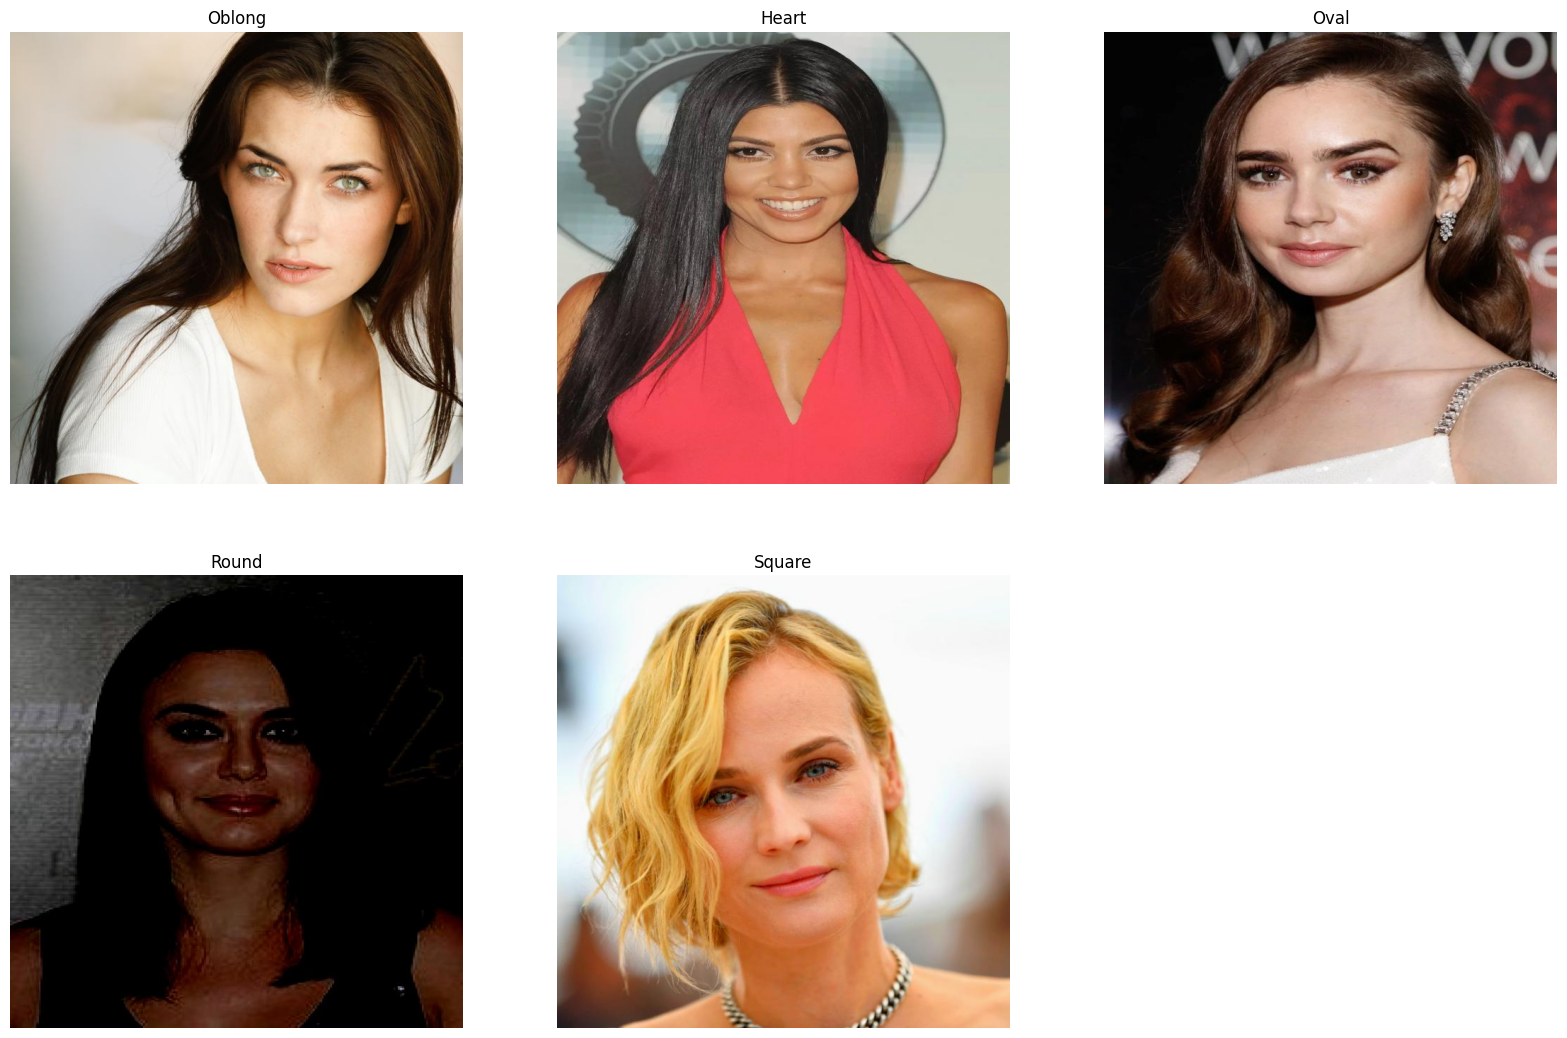

In [12]:
cn = 0
plt.figure(figsize=(20,20))
for unique_label in data['label'].unique():
    plt.subplot(3, 3, cn+1)
    plt.imshow(plt.imread(data[data['label']==unique_label].iloc[0,0]))
    plt.title(unique_label)
    plt.axis('off')
    cn+=1

In [13]:
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=True, random_state=42)

In [14]:
train_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # Fungsi preprocessing yang digunakan sebelumnya
    validation_split=0.2, # Augmentasi yang diterapkan pada data pelatihan
    # shear_range=0.2,          # Mengubah sudut gambar
    # zoom_range=0.2,           # Zoom in/out gambar
    # horizontal_flip=True,     # Membalik gambar secara horizontal
    # rotation_range=30,        # Rotasi gambar dalam derajat
    # width_shift_range=0.2,    # Pergeseran gambar secara horizontal
    # height_shift_range=0.2,   # Pergeseran gambar secara vertikal
    # fill_mode='nearest'       # Cara mengisi area yang kosong setelah transformasi
)

test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

In [15]:
train_images = train_generator.flow_from_dataframe(dataframe=train_data, x_col='path', y_col='label', target_size=(224, 224), color_mode='rgb', class_mode='categorical', batch_size=32, shuffle=True, seed=42, subset='training')
val_images = train_generator.flow_from_dataframe(dataframe=train_data, x_col='path', y_col='label', target_size=(224, 224), color_mode='rgb', class_mode='categorical', batch_size=32, shuffle=True, seed=42, subset='validation' )
test_images = test_generator.flow_from_dataframe(dataframe=test_data, x_col='path', y_col='label', target_size=(224, 224), color_mode='rgb', class_mode='categorical', batch_size=32, shuffle=False )

Found 6410 validated image filenames belonging to 5 classes.
Found 1602 validated image filenames belonging to 5 classes.
Found 2004 validated image filenames belonging to 5 classes.


In [16]:
display(train_images.class_indices)
display(val_images.class_indices)
display(test_images.class_indices)

{'Heart': 0, 'Oblong': 1, 'Oval': 2, 'Round': 3, 'Square': 4}

{'Heart': 0, 'Oblong': 1, 'Oval': 2, 'Round': 3, 'Square': 4}

{'Heart': 0, 'Oblong': 1, 'Oval': 2, 'Round': 3, 'Square': 4}

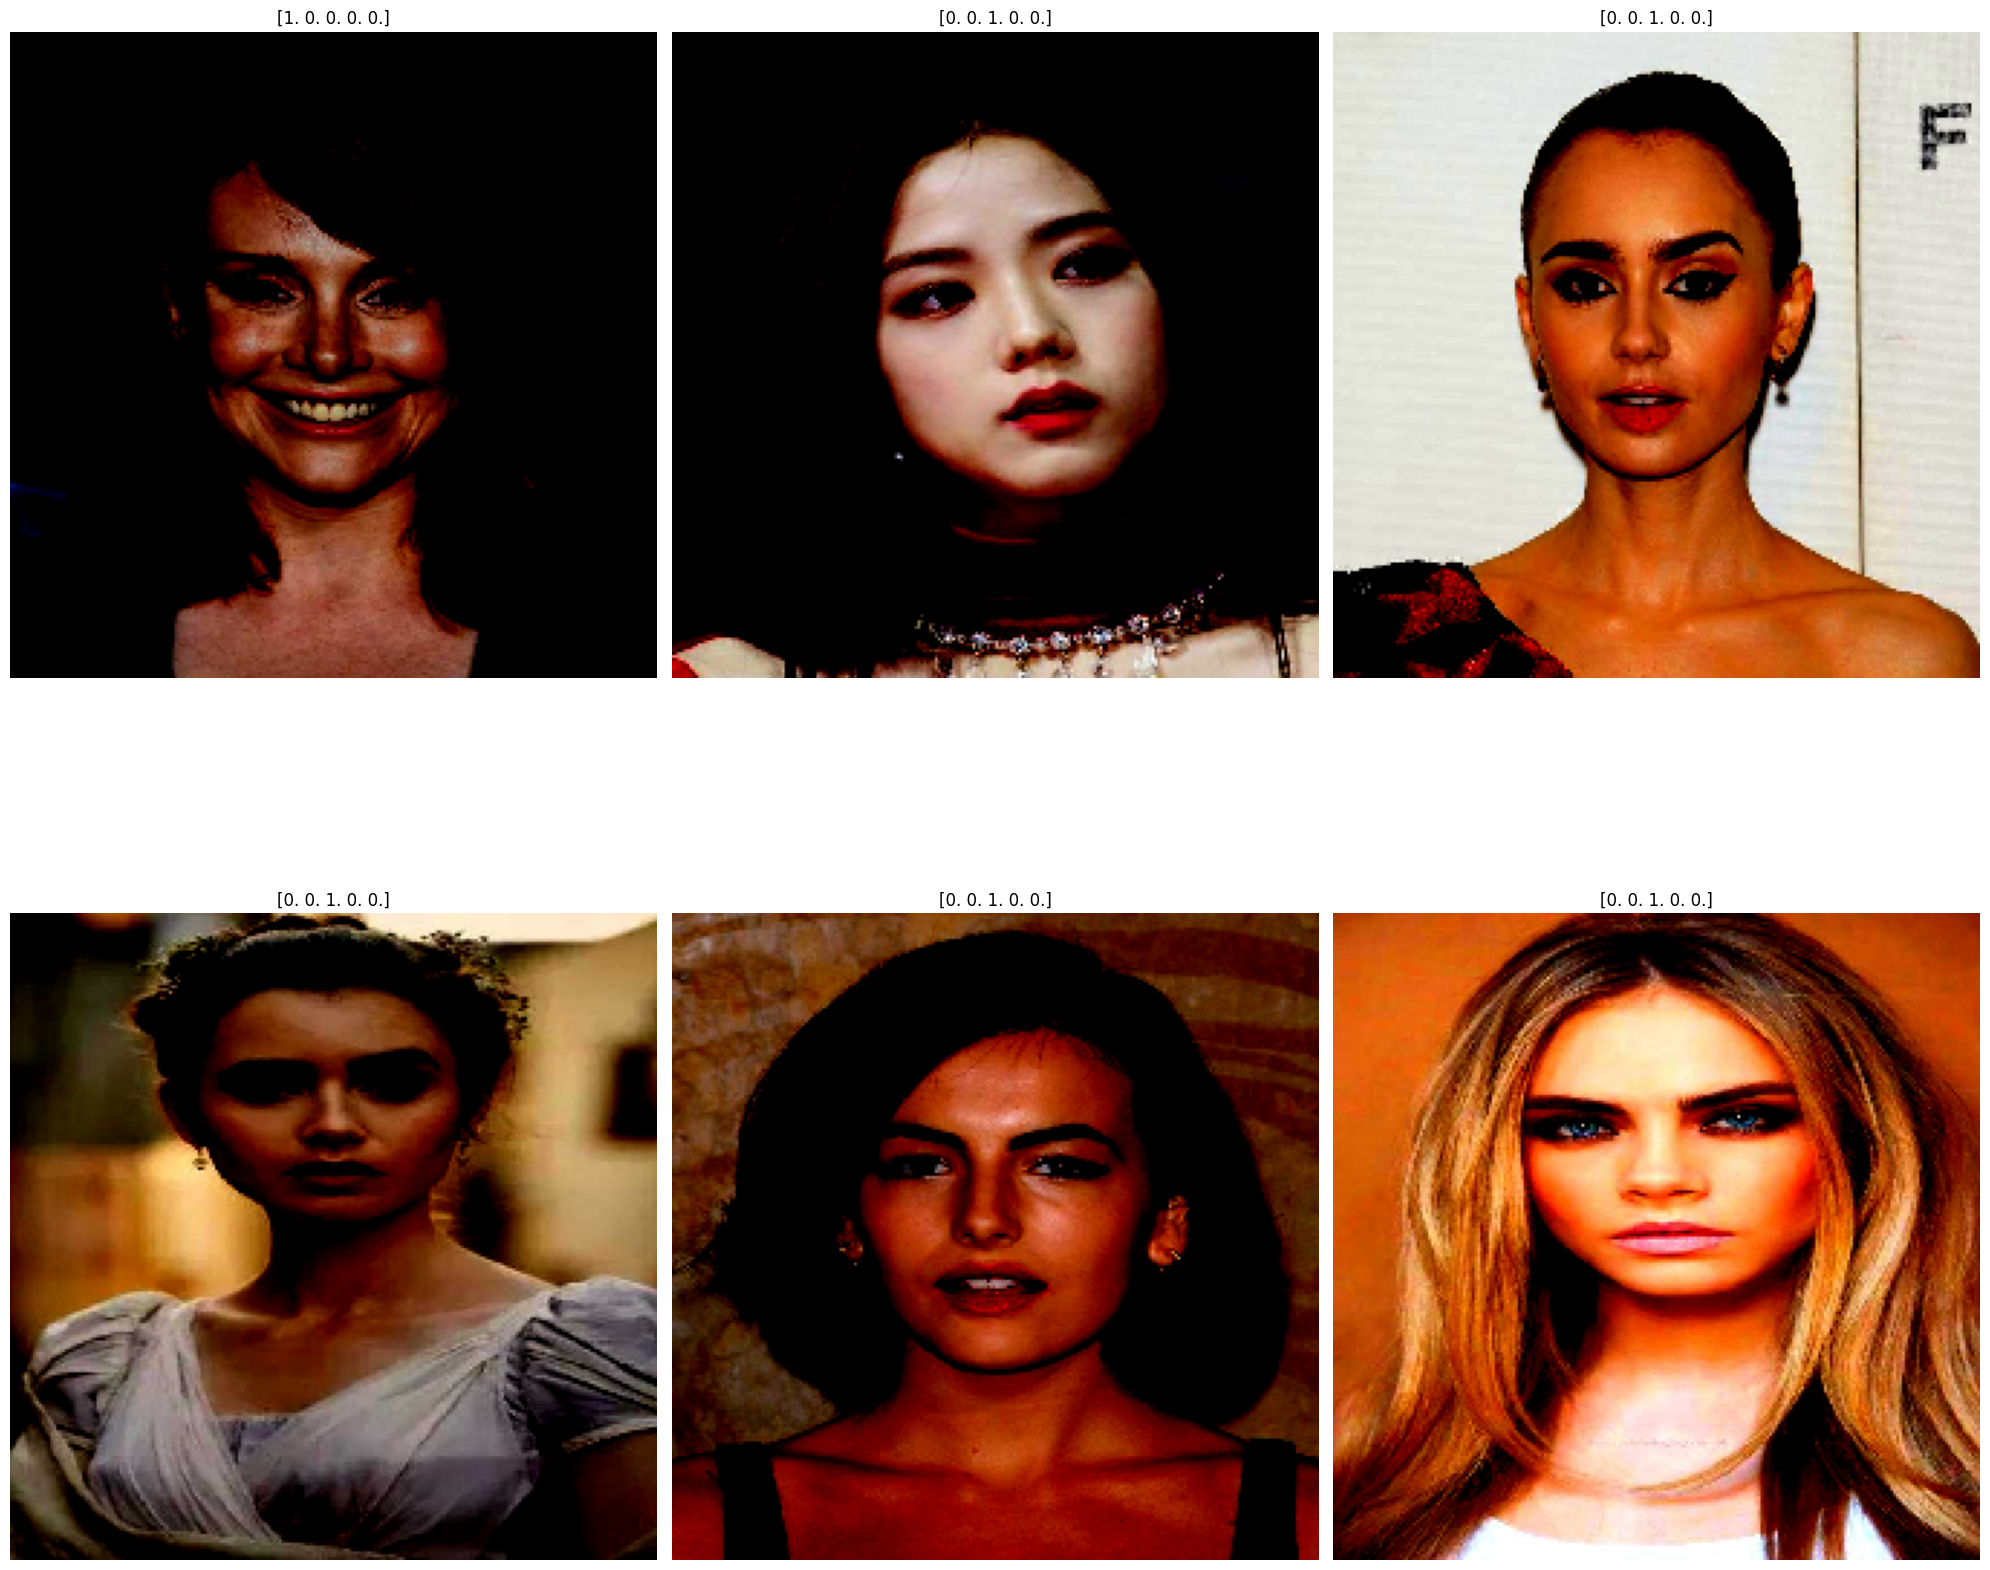

In [17]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20,20))
ax = ax.flatten()

for j in range(6):
    img, label = next(val_images)


    if isinstance(label, (list, np.ndarray)):
        label = label[0]

    if not isinstance(label, str):
        label = str(label)

    ax[j].imshow(img[0])
    ax[j].set_title(label)
    ax[j].axis('off')

plt.tight_layout()
plt.show()

In [41]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

# Unfreeze some layers in the base model to allow fine-tuning
for layer in pretrained_model.layers[-4:]:
    layer.trainable = True


In [42]:
# Apply data augmentation to the training set

x = Dense(128, activation='relu')(pretrained_model.output)
x = Dropout(0.5)(x)  # Tambahkan Dropout untuk regularisasi
x = Dense(1024, activation='relu')(x)

outputs = Dense(5, activation='softmax')(x)

# Bangun model dengan input dan output yang ditentukan
model = Model(inputs=pretrained_model.input, outputs=outputs)

In [43]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,559,173 (9.76 MB)

 Trainable params: 713,349 (2.72 MB)

 Non-trainable params: 1,845,824 (7.04 MB)

In [44]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

# Callback: EarlyStopping dan ModelCheckpoint
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# Early Stoping
earlystop_cb = EarlyStopping(patience=10, restore_best_weights=True)

# ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True)

history = model.fit(train_images,
                    validation_data=val_images,
                    epochs=50,
                    callbacks=[checkpoint, earlystop_cb, reduce_lr])

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


201/201 ━━━━━━━━━━━━━━━━━━━━ 51s 186ms/step - accuracy: 0.3148 - loss: 1.5397 - val_accuracy: 0.3452 - val_loss: 1.5629 - learning_rate: 0.0010
Epoch 2/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 63s 131ms/step - accuracy: 0.4755 - loss: 1.2787 - val_accuracy: 0.4164 - val_loss: 1.3916 - learning_rate: 0.0010
Epoch 3/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 27s 132ms/step - accuracy: 0.5576 - loss: 1.0941 - val_accuracy: 0.5162 - val_loss: 1.2762 - learning_rate: 0.0010
Epoch 4/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 41s 131ms/step - accuracy: 0.6510 - loss: 0.9063 - val_accuracy: 0.5762 - val_loss: 1.1295 - learning_rate: 0.0010
Epoch 5/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 40s 130ms/step - accuracy: 0.7169 - loss: 0.7404 - val_accuracy: 0.6092 - val_loss: 1.0559 - learning_rate: 0.0010
Epoch 6/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 41s 129ms/step - accuracy: 0.7689 - loss: 0.6210 - val_accuracy: 0.6361 - val_loss: 1.0066 - learning_rate: 0.0010
Epoch 7/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 41s 130ms/step - accuracy: 0.8062 - loss:

In [45]:
model.evaluate(test_images, verbose=0)

[0.5681846141815186, 0.8772454857826233]

In [46]:
pred = model.predict(test_images)
pred = np.argmax(pred, axis=1)

63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step


In [47]:
predict_data=test_data.copy()
labels={}
for l,v in test_images.class_indices.items():
    labels.update({v:l})
predict_data['pred']=pred
predict_data['pred']=predict_data['pred'].apply(lambda x: labels[x])

In [48]:
predict_data=predict_data.reset_index(drop=True)
predict_data.head(10)
predict_data=predict_data.reset_index(drop=True)
predict_data.head(10)

path   label    pred
0  /root/.cache/kagglehub/datasets/fakhrizakiiii/...  Oblong  Oblong
1  /root/.cache/kagglehub/datasets/fakhrizakiiii/...  Square  Square
2  /root/.cache/kagglehub/datasets/fakhrizakiiii/...   Heart   Heart
3  /root/.cache/kagglehub/datasets/fakhrizakiiii/...  Oblong   Round
4  /root/.cache/kagglehub/datasets/fakhrizakiiii/...   Round   Round
5  /root/.cache/kagglehub/datasets/fakhrizakiiii/...  Square    Oval
6  /root/.cache/kagglehub/datasets/fakhrizakiiii/...   Round   Round
7  /root/.cache/kagglehub/datasets/fakhrizakiiii/...   Round   Round
8  /root/.cache/kagglehub/datasets/fakhrizakiiii/...   Heart   Heart
9  /root/.cache/kagglehub/datasets/fakhrizakiiii/...   Round   Round

In [49]:
predict_data[predict_data['label']!=predict_data['pred']]

path   label    pred
3     /root/.cache/kagglehub/datasets/fakhrizakiiii/...  Oblong   Round
5     /root/.cache/kagglehub/datasets/fakhrizakiiii/...  Square    Oval
47    /root/.cache/kagglehub/datasets/fakhrizakiiii/...   Round   Heart
55    /root/.cache/kagglehub/datasets/fakhrizakiiii/...    Oval   Heart
57    /root/.cache/kagglehub/datasets/fakhrizakiiii/...    Oval   Round
...                                                 ...     ...     ...
1956  /root/.cache/kagglehub/datasets/fakhrizakiiii/...  Square   Round
1958  /root/.cache/kagglehub/datasets/fakhrizakiiii/...    Oval  Square
1989  /root/.cache/kagglehub/datasets/fakhrizakiiii/...  Square    Oval
1994  /root/.cache/kagglehub/datasets/fakhrizakiiii/...   Heart  Oblong
2002  /root/.cache/kagglehub/datasets/fakhrizakiiii/...  Square   Round

[246 rows x 3 columns]

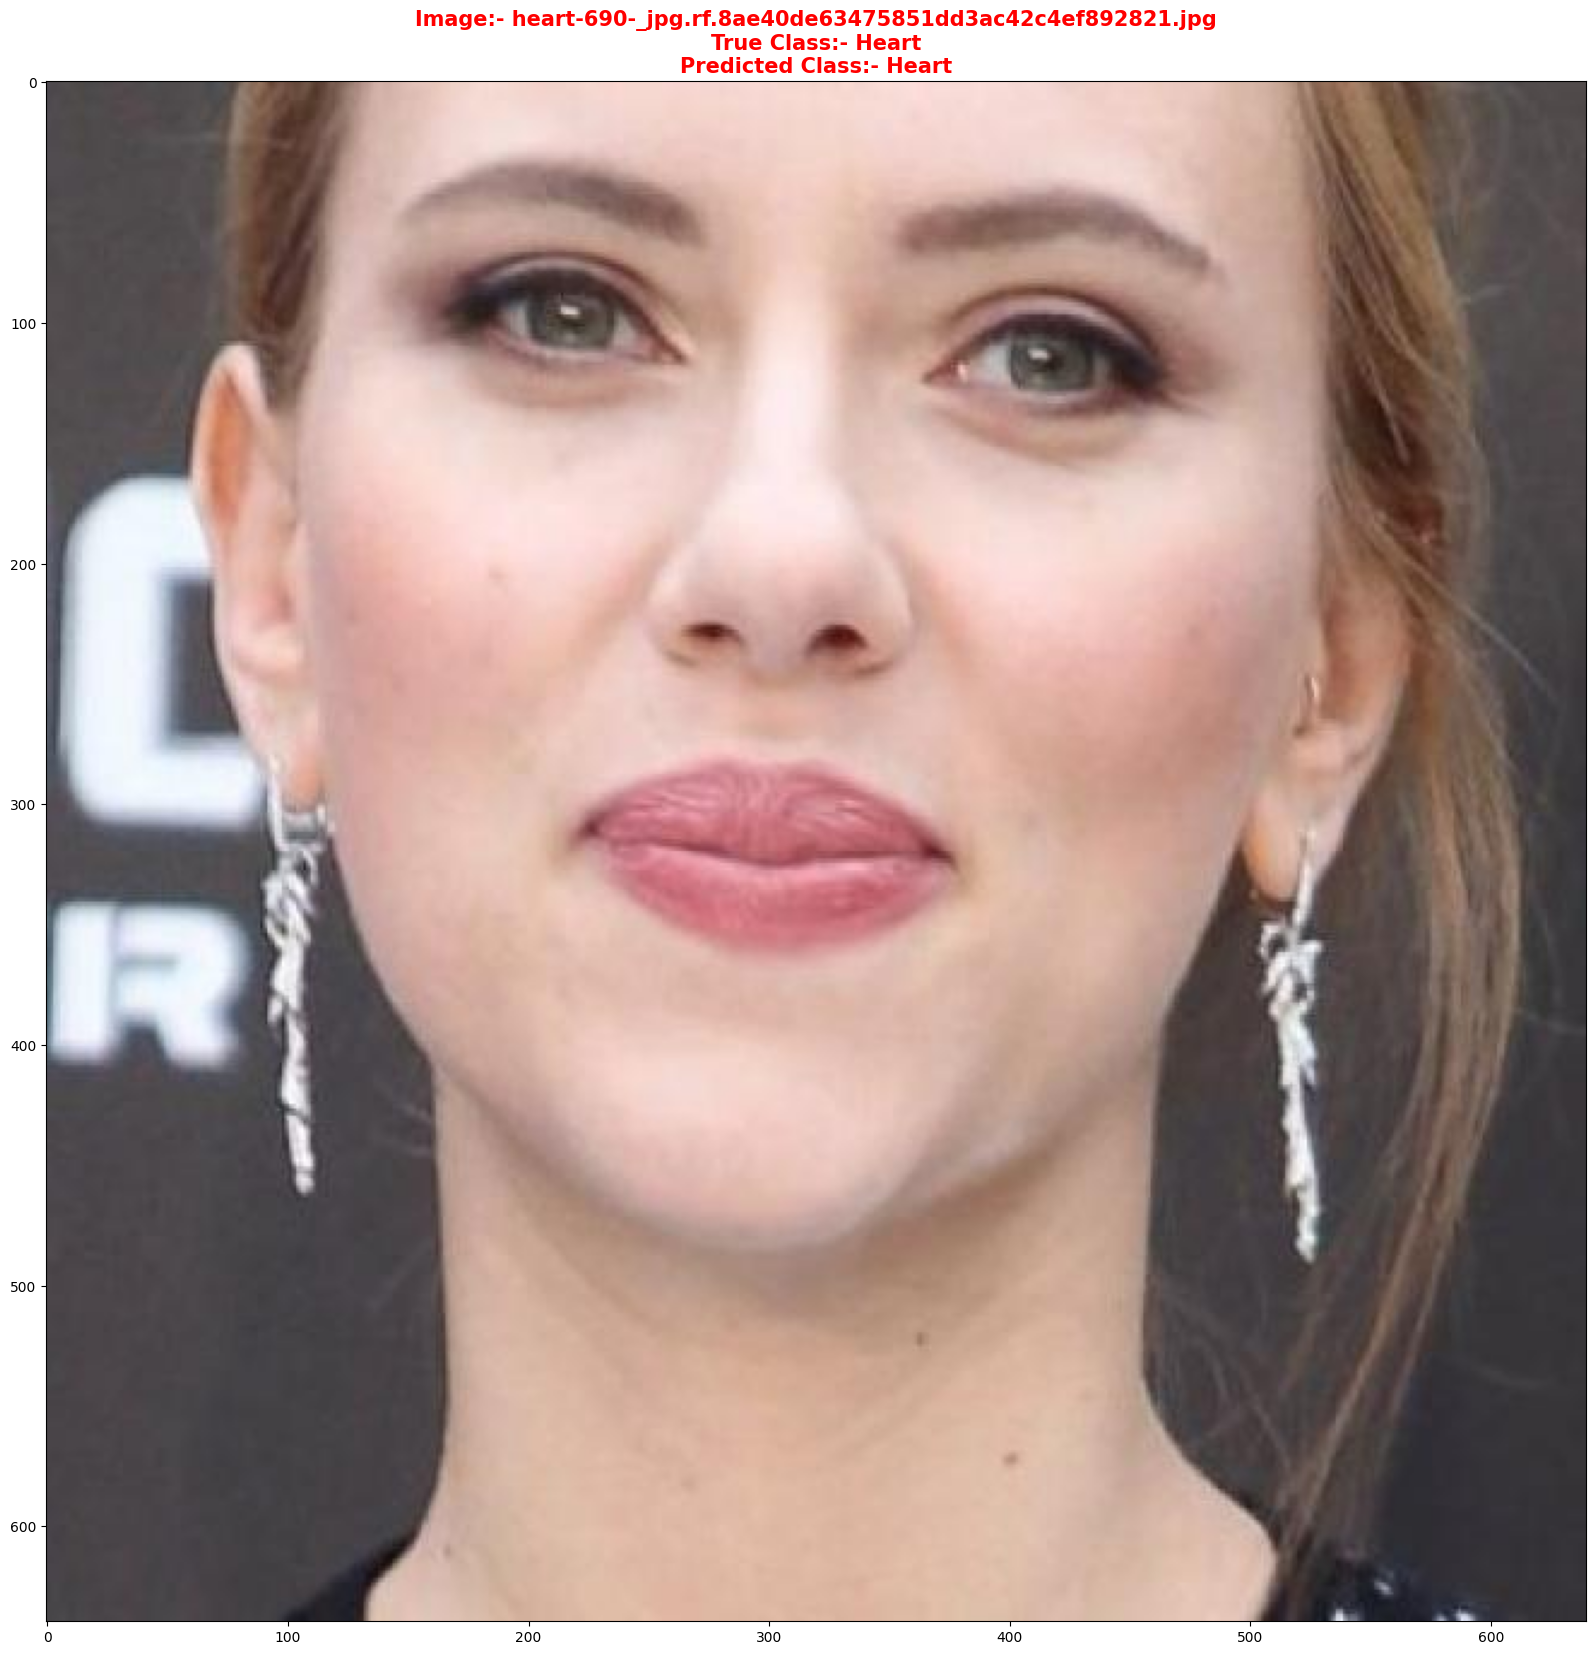

In [50]:
plt.figure(figsize=(20,20))
plt.imshow(plt.imread(predict_data.path[1601]))
title1 = predict_data.path[1601].split('/')[-2]
title2 = predict_data.path[1601].split('/')[-1]
title3 = predict_data.pred[1601]
plt.title(f'Image:- {title2}\nTrue Class:- {title1}\nPredicted Class:- {title3}', color = 'r', weight = 'bold', fontsize = 15)
plt.show()

Accuracy Score: 0.8772455089820359


<Axes: >

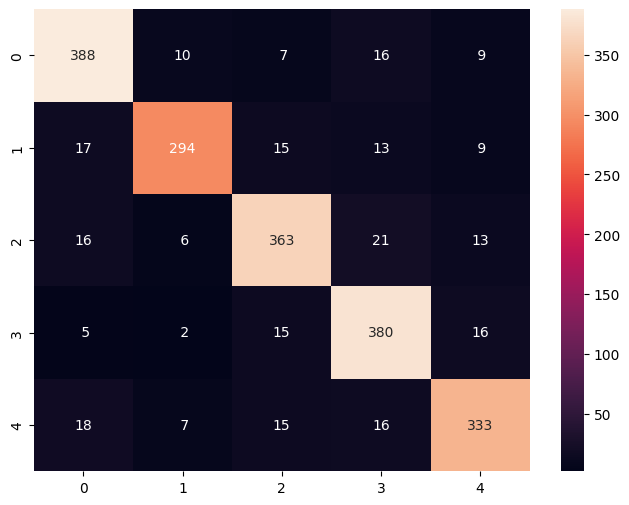

In [51]:
print(f"Accuracy Score: {accuracy_score(predict_data['label'],predict_data['pred'])}")
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(predict_data['label'],predict_data['pred']), annot=True, fmt='2d')

In [52]:
print(classification_report(predict_data['label'],predict_data['pred']))

              precision    recall  f1-score   support

       Heart       0.87      0.90      0.89       430
      Oblong       0.92      0.84      0.88       348
        Oval       0.87      0.87      0.87       419
       Round       0.85      0.91      0.88       418
      Square       0.88      0.86      0.87       389

    accuracy                           0.88      2004
   macro avg       0.88      0.88      0.88      2004
weighted avg       0.88      0.88      0.88      2004



In [53]:
model.save('best_model.keras')

In [54]:
from google.colab import files

files.download('best_model.keras')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>